# Demo of Variational Interpretable Concept Embeddings (VICE)

## Install dependencies

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import argparse
import os
import random
import torch

import numpy as np
from typing import Tuple

import utils
import visualization
import optimization
from data import TripletData
from torch.utils.data import DataLoader

## I/O

In [53]:
# specify input and output directories
# triplets_dir = './data/files/amt/'
triplets_dir = './data/own/rgbg'

# for rgbg
results_dir = './output_own/rgbg/results/'
plots_dir = './output_own/rgbg/plots/'

#for usa
triplets_dir = './data/own/usa/'
results_dir = './output_own/usa/results/'
plots_dir = './output_own/usa/plots/'

### Variables and hyperparameters

In [54]:
# define variables
task = 'odd-one-out' # whether to perform an odd-one-out (3AFC) or target-matching (2AFC) triplet task
epochs = 1500 # maximum number of epochs to run optimization process
burnin = 500 # minimum number of epochs to run optimization process
init_dim = 100 # initial embedding dimensionality of VICE
batch_size = 128 # use power of 2 if you intend to perfrom model training on a GPU, else see whatever works best for you
optim = 'adam' # we recommend to use Adam but you can try SGD with momentum
mixture = 'gaussian' # spike-and-slab Gaussian mixture prior (if set to "laplace", a mixture of two Laplace distributions will be used as the prior)
mc_samples = 10 # number of weight samples used in Monte Carlo (MC) sampling
eta = 1e-3 # learning rate used in the optimizer
spike = 0.1 # sigma (width) of the spike distribution
slab = 1.0 # sigma (width) of the slab distribution
pi = 0.5 # probability value that determines the relative weighting of the two distributions; the closer this value is to 1, the higher the probability that weights are drawn from the spike distribution
k = 5 # an embedding dimension is considered important (and won't be pruned) if the minimum number of objects with a non-zero weight is larger than k (we recommend to set this value to 5 or 10)
ws = 200 # window size determines for how many epochs the number of embedding dimensions (after pruning) is not allowed to vary (ws >> 100)
steps = 50 # perform validation, save model parameters and create model and optimizer checkpoints every <steps> epochs
seed = 42 # random seed for reproducibility of results
num_workers = 8 # number of workers used for loading data
verbose = True # enable verbosity

In [55]:
# seed random number generator
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(seed)
else:
    # number of threads used for intraop parallelism on CPU; use only if device is CPU (won't affect performance on GPU)
    num_threads = 8
    torch.set_num_threads(num_threads)
    os.environ['OMP_NUM_THREADS'] = str(num_threads)
    device = torch.device('cpu')

In [56]:
# utility function
def get_nobjects(train_triplets: torch.Tensor) -> int:
    """Get number of unique items in the data."""
    n_objects = torch.max(train_triplets).item()
    if torch.min(train_triplets).item() == 0:
        n_objects += 1
    return n_objects

### RB: create test and train set

In [ ]:
# nx3 simulierte daten mit 768, n=750k

In [13]:
my_data = np.genfromtxt('./data/own/rgbg.csv', delimiter=',', dtype=np.int32)
len_data = my_data.shape[0]
indices = np.random.permutation(len_data)
training_idx, test_idx = indices[:-int(len_data/10)], indices[-int(len_data/10):]
training, test = my_data[training_idx,:], my_data[test_idx,:]

In [31]:
# rgbg data, remapped stimuli names
my_data = np.genfromtxt('./data/own/rgbg/rgbg.csv', delimiter=',', dtype=np.int32)

unique_ids = []
for x in my_data:
    for xy in x:
        unique_ids.append(xy)
unique_ids = set(unique_ids)
mapping = {list(unique_ids)[i]:i for i in range(len(unique_ids))}

for i in range(len(my_data)):
    for j in range(3):
        my_data[i][j] = mapping[my_data[i][j]]
        

len_data = my_data.shape[0]
indices = np.random.permutation(len_data)
training_idx, test_idx = indices[:-int(len_data/10)], indices[-int(len_data/10):]
training, test = my_data[training_idx,:], my_data[test_idx,:]

In [57]:
# usa data, remapped stimuli names
my_data = np.genfromtxt('./data/own/usa/usa.csv', delimiter=',', dtype=np.int32)

unique_ids = []
for x in my_data:
    for xy in x:
        unique_ids.append(xy)
unique_ids = set(unique_ids)
mapping = {list(unique_ids)[i]:i for i in range(len(unique_ids))}

for i in range(len(my_data)):
    for j in range(3):
        my_data[i][j] = mapping[my_data[i][j]]
        

len_data = my_data.shape[0]
indices = np.random.permutation(len_data)
training_idx, test_idx = indices[:-int(len_data/10)], indices[-int(len_data/10):]
training, test = my_data[training_idx,:], my_data[test_idx,:]

In [62]:
len(my_data)

34590

In [ ]:
# usa data, remapped stimuli names

In [58]:
np.save(triplets_dir + 'train_90.npy', training)
np.save(triplets_dir + 'test_10.npy', test)

### Create mini-batches of train and test triplets

In [59]:
# load train and test triplets into memory
train_triplets, val_triplets = utils.load_data(device=device, triplets_dir=triplets_dir)

# get number of samples/trials and number of unique objects in the data
N = train_triplets.shape[0] # number of training samples
n_objects = get_nobjects(train_triplets) # number of objects in the data

# double-check whether the number of objects was inferred correctly from the train set
print(f'\nNumber of objects in the dataset: {n_objects}\n')


Number of objects in the dataset: 48



In [63]:
# create tensor datasets for the triplet data
train_triplets = TripletData(
    triplets=train_triplets,
    n_objects=n_objects,
)
val_triplets = TripletData(
    triplets=val_triplets,
    n_objects=n_objects,
)

In [64]:
# load mini-batches for training
train_batches = DataLoader(
    dataset=train_triplets,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
    pin_memory=True,
)
# load mini-batches for evaluation
val_batches = DataLoader(
    dataset=val_triplets,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
    pin_memory=False,
)

### Create directories

In [65]:
# helper to create directories for storing results
def create_dirs(
                results_dir: str,
                plots_dir: str,
                init_dim: int,
                optim: str,
                mixture: str,
                spike: float,
                slab: float,
                pi: float,
                rnd_seed: int,
) -> Tuple[str, str, str]:
    """Create directories for results, plots, and model parameters."""
    print('\n...Creating directories.\n')
#    if results_dir == './results/':
    if results_dir == './output_own/results/':
        results_dir = os.path.join(
                                    results_dir,
                                    f'{init_dim}d',
                                    optim,
                                    mixture,
                                    str(spike),
                                    str(slab),
                                    str(pi),
                                    f'seed{rnd_seed:02d}',
        )
    if not os.path.exists(results_dir):
        os.makedirs(results_dir, exist_ok=True)
        
#    if plots_dir == './plots/':
    if plots_dir == './output_own/plots/':
        plots_dir = os.path.join(
                                 plots_dir,
                                 f'{init_dim}d',
                                 optim,
                                 mixture,
                                 str(spike),
                                 str(slab),
                                 str(pi),
                                 f'seed{rnd_seed:02d}',
        )
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir, exist_ok=True)
        
    model_dir = os.path.join(results_dir, 'model')
    return results_dir, plots_dir, model_dir

In [66]:
results_dir, plots_dir, model_dir = create_dirs(
                            results_dir=results_dir,
                            plots_dir=plots_dir,
                            init_dim=init_dim,
                            optim=optim,
                            mixture=mixture,
                            spike=spike,
                            slab=slab,
                            pi=pi,
                            rnd_seed=seed
)


...Creating directories.



## VICE optimization

In [67]:
# initialize VICE model
vice = optimization.VICE(
            task=task,
            n_train=N,
            n_objects=n_objects,
            init_dim=init_dim,
            optim=optim,
            eta=eta,
            batch_size=batch_size,
            epochs=epochs,
            burnin=burnin,
            mc_samples=mc_samples,
            mixture=mixture,
            spike=spike,
            slab=slab,
            pi=pi,
            k=k,
            ws=ws,
            steps=steps,
            model_dir=model_dir,
            results_dir=results_dir,
            device=device,
            verbose=verbose,
            init_weights=True,
    )

# move VICE to current device
vice.to(device)

# perform VICE optimization (i.e., fit model to the training data and perform evaluation and save model params every <steps> epochs)
vice.fit(train_batches=train_batches, val_batches=val_batches)

# fitting ~1h mit rgbg daten


====== Epoch: 01, Train acc: 0.378, Train loss: 1.869, Identified dimensions: 100 ======


====== Epoch: 02, Train acc: 0.424, Train loss: 1.787, Identified dimensions: 100 ======


====== Epoch: 03, Train acc: 0.436, Train loss: 1.738, Identified dimensions: 100 ======


====== Epoch: 04, Train acc: 0.440, Train loss: 1.696, Identified dimensions: 99 ======


====== Epoch: 05, Train acc: 0.439, Train loss: 1.655, Identified dimensions: 90 ======


====== Epoch: 06, Train acc: 0.439, Train loss: 1.615, Identified dimensions: 74 ======


====== Epoch: 07, Train acc: 0.444, Train loss: 1.575, Identified dimensions: 65 ======


====== Epoch: 08, Train acc: 0.445, Train loss: 1.536, Identified dimensions: 59 ======


====== Epoch: 09, Train acc: 0.449, Train loss: 1.497, Identified dimensions: 56 ======


====== Epoch: 10, Train acc: 0.449, Train loss: 1.459, Identified dimensions: 56 ======


====== Epoch: 11, Train acc: 0.453, Train loss: 1.422, Identified dimensions: 55 ======


======


====== Epoch: 33, Train acc: 0.452, Train loss: 1.151, Identified dimensions: 12 ======


====== Epoch: 34, Train acc: 0.458, Train loss: 1.148, Identified dimensions: 12 ======


====== Epoch: 35, Train acc: 0.452, Train loss: 1.149, Identified dimensions: 11 ======


====== Epoch: 36, Train acc: 0.452, Train loss: 1.147, Identified dimensions: 11 ======


====== Epoch: 37, Train acc: 0.452, Train loss: 1.147, Identified dimensions: 11 ======


====== Epoch: 38, Train acc: 0.455, Train loss: 1.146, Identified dimensions: 11 ======


====== Epoch: 39, Train acc: 0.452, Train loss: 1.145, Identified dimensions: 11 ======


====== Epoch: 40, Train acc: 0.452, Train loss: 1.144, Identified dimensions: 11 ======


====== Epoch: 41, Train acc: 0.450, Train loss: 1.145, Identified dimensions: 11 ======


====== Epoch: 42, Train acc: 0.452, Train loss: 1.144, Identified dimensions: 10 ======


====== Epoch: 43, Train acc: 0.452, Train loss: 1.143, Identified dimensions: 10 ======


====== Ep


====== Epoch: 65, Train acc: 0.453, Train loss: 1.136, Identified dimensions: 09 ======


====== Epoch: 66, Train acc: 0.451, Train loss: 1.137, Identified dimensions: 08 ======


====== Epoch: 67, Train acc: 0.450, Train loss: 1.137, Identified dimensions: 08 ======


====== Epoch: 68, Train acc: 0.452, Train loss: 1.136, Identified dimensions: 08 ======


====== Epoch: 69, Train acc: 0.451, Train loss: 1.137, Identified dimensions: 09 ======


====== Epoch: 70, Train acc: 0.452, Train loss: 1.136, Identified dimensions: 09 ======


====== Epoch: 71, Train acc: 0.453, Train loss: 1.136, Identified dimensions: 09 ======


====== Epoch: 72, Train acc: 0.454, Train loss: 1.136, Identified dimensions: 09 ======


====== Epoch: 73, Train acc: 0.455, Train loss: 1.136, Identified dimensions: 09 ======


====== Epoch: 74, Train acc: 0.450, Train loss: 1.136, Identified dimensions: 09 ======


====== Epoch: 75, Train acc: 0.452, Train loss: 1.137, Identified dimensions: 09 ======


====== Ep


====== Epoch: 97, Train acc: 0.447, Train loss: 1.135, Identified dimensions: 07 ======


====== Epoch: 98, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 99, Train acc: 0.446, Train loss: 1.136, Identified dimensions: 07 ======


====== Epoch: 100, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 101, Train acc: 0.447, Train loss: 1.136, Identified dimensions: 07 ======


====== Epoch: 102, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 103, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 104, Train acc: 0.452, Train loss: 1.134, Identified dimensions: 07 ======


====== Epoch: 105, Train acc: 0.451, Train loss: 1.134, Identified dimensions: 07 ======


====== Epoch: 106, Train acc: 0.451, Train loss: 1.134, Identified dimensions: 08 ======


====== Epoch: 107, Train acc: 0.452, Train loss: 1.134, Identified dimensions: 08 ======


=


====== Epoch: 128, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 129, Train acc: 0.452, Train loss: 1.134, Identified dimensions: 08 ======


====== Epoch: 130, Train acc: 0.452, Train loss: 1.134, Identified dimensions: 08 ======


====== Epoch: 131, Train acc: 0.448, Train loss: 1.135, Identified dimensions: 08 ======


====== Epoch: 132, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 08 ======


====== Epoch: 133, Train acc: 0.453, Train loss: 1.134, Identified dimensions: 08 ======


====== Epoch: 134, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 135, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 136, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 137, Train acc: 0.454, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 138, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 08 ======



====== Epoch: 159, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 160, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 161, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 162, Train acc: 0.445, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 163, Train acc: 0.454, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 164, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 165, Train acc: 0.455, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 166, Train acc: 0.456, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 167, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 168, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 169, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======



====== Epoch: 190, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 191, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 192, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 193, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 194, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 195, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 196, Train acc: 0.451, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 197, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 198, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 199, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 200, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======



====== Epoch: 221, Train acc: 0.446, Train loss: 1.135, Identified dimensions: 10 ======


====== Epoch: 222, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 223, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 224, Train acc: 0.451, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 225, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 226, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 227, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 228, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 229, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 230, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 231, Train acc: 0.447, Train loss: 1.136, Identified dimensions: 10 ======



====== Epoch: 252, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 253, Train acc: 0.450, Train loss: 1.134, Identified dimensions: 11 ======


====== Epoch: 254, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 255, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 256, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 257, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 258, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 259, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 11 ======


====== Epoch: 260, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 261, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 262, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 11 ======



====== Epoch: 283, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 284, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 285, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 286, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 287, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 288, Train acc: 0.447, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 289, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 290, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 291, Train acc: 0.455, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 292, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 11 ======


====== Epoch: 293, Train acc: 0.456, Train loss: 1.133, Identified dimensions: 11 ======



====== Epoch: 314, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 12 ======


====== Epoch: 315, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 12 ======


====== Epoch: 316, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 12 ======


====== Epoch: 317, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 318, Train acc: 0.448, Train loss: 1.135, Identified dimensions: 12 ======


====== Epoch: 319, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 320, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 321, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 322, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 11 ======


====== Epoch: 323, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 324, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 11 ======



====== Epoch: 345, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 346, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 11 ======


====== Epoch: 347, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 348, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 349, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 11 ======


====== Epoch: 350, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 351, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 11 ======


====== Epoch: 352, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 353, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 354, Train acc: 0.451, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 355, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 11 ======



====== Epoch: 376, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 377, Train acc: 0.450, Train loss: 1.135, Identified dimensions: 10 ======


====== Epoch: 378, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 11 ======


====== Epoch: 379, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 380, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 381, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 382, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 383, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 384, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 385, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 386, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======



====== Epoch: 407, Train acc: 0.447, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 408, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 409, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 410, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 411, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 412, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 413, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 414, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 415, Train acc: 0.455, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 416, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 417, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 438, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 439, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 440, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 441, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 442, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 443, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 444, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 445, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 446, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 447, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 448, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 469, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 470, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 471, Train acc: 0.450, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 472, Train acc: 0.451, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 473, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 474, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 475, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 476, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 477, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 09 ======


====== Epoch: 478, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 479, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 09 ======



====== Epoch: 500, Train acc: 0.452, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 501, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 502, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 503, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 504, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 505, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 506, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 507, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 508, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 509, Train acc: 0.448, Train loss: 1.135, Identified dimensions: 10 ======


====== Epoch: 510, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 10 ======



====== Epoch: 531, Train acc: 0.456, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 532, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 533, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 534, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 535, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 536, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 537, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 538, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 539, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 540, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 541, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======



====== Epoch: 562, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 563, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 564, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 565, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 566, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 09 ======


====== Epoch: 567, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 568, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 569, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 570, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 571, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 572, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======



====== Epoch: 593, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 594, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 595, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 596, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 597, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 598, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 599, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 600, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 601, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 602, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 603, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 624, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 625, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 626, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 627, Train acc: 0.455, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 628, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 629, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 630, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 631, Train acc: 0.448, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 632, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 633, Train acc: 0.450, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 634, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 655, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 656, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 657, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 658, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 659, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 660, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 661, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 662, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 663, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 664, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 665, Train acc: 0.454, Train loss: 1.133, Identified dimensions: 10 ======



====== Epoch: 686, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 687, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 688, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 689, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 690, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 691, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 692, Train acc: 0.445, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 693, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 694, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 695, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 696, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 10 ======



====== Epoch: 717, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 718, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 719, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 720, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 721, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 722, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 723, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 724, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 725, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 726, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 727, Train acc: 0.448, Train loss: 1.132, Identified dimensions: 10 ======



====== Epoch: 748, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 749, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 750, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 09 ======


====== Epoch: 751, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 752, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 753, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 754, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 755, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 756, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 757, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 09 ======


====== Epoch: 758, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 779, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 780, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 781, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 782, Train acc: 0.449, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 783, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 784, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 785, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 10 ======


====== Epoch: 786, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 787, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 788, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 789, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======



====== Epoch: 810, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 811, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 812, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 813, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 814, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 815, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 816, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 817, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 818, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 819, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 820, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======



====== Epoch: 841, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 10 ======


====== Epoch: 842, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 843, Train acc: 0.450, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 844, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 845, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 10 ======


====== Epoch: 846, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 847, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 848, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 849, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 850, Train acc: 0.451, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 851, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======



====== Epoch: 872, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 873, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 874, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 875, Train acc: 0.448, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 876, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 877, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 878, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 09 ======


====== Epoch: 879, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 880, Train acc: 0.448, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 881, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 882, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 10 ======



====== Epoch: 903, Train acc: 0.451, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 904, Train acc: 0.448, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 905, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 906, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 907, Train acc: 0.451, Train loss: 1.131, Identified dimensions: 09 ======


====== Epoch: 908, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 909, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 910, Train acc: 0.447, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 911, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 912, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 913, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 934, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 935, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 936, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 937, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 938, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 939, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 940, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 941, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 942, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 943, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 944, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 965, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 966, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 967, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 09 ======


====== Epoch: 968, Train acc: 0.448, Train loss: 1.135, Identified dimensions: 09 ======


====== Epoch: 969, Train acc: 0.448, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 970, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 971, Train acc: 0.448, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 972, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 973, Train acc: 0.450, Train loss: 1.134, Identified dimensions: 09 ======


====== Epoch: 974, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 975, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======



====== Epoch: 996, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 997, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 998, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 999, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1000, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 10 ======


====== Epoch: 1001, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1002, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1003, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1004, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 1005, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 1006, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 09 


====== Epoch: 1027, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1028, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1029, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1030, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1031, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1032, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1033, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1034, Train acc: 0.450, Train loss: 1.134, Identified dimensions: 08 ======


====== Epoch: 1035, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1036, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1037, Train acc: 0.449, Train loss: 1.133, Identified dimensions:


====== Epoch: 1058, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1059, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1060, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1061, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1062, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1063, Train acc: 0.450, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1064, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1065, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1066, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1067, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1068, Train acc: 0.449, Train loss: 1.133, Identified dimensions:


====== Epoch: 1089, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 1090, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1091, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1092, Train acc: 0.450, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1093, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1094, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1095, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1096, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1097, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1098, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1099, Train acc: 0.450, Train loss: 1.132, Identified dimensions:


====== Epoch: 1120, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 1121, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 1122, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1123, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1124, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1125, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1126, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 1127, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 09 ======


====== Epoch: 1128, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 1129, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 09 ======


====== Epoch: 1130, Train acc: 0.452, Train loss: 1.132, Identified dimensions:


====== Epoch: 1151, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1152, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1153, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1154, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1155, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1156, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1157, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1158, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1159, Train acc: 0.452, Train loss: 1.134, Identified dimensions: 08 ======


====== Epoch: 1160, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1161, Train acc: 0.451, Train loss: 1.133, Identified dimensions:


====== Epoch: 1182, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1183, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1184, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1185, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1186, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1187, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1188, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1189, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1190, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1191, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1192, Train acc: 0.451, Train loss: 1.132, Identified dimensions:


====== Epoch: 1213, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1214, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1215, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1216, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1217, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1218, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1219, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1220, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1221, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1222, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1223, Train acc: 0.449, Train loss: 1.133, Identified dimensions:


====== Epoch: 1244, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1245, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1246, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1247, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1248, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1249, Train acc: 0.450, Train loss: 1.134, Identified dimensions: 07 ======


====== Epoch: 1250, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1251, Train acc: 0.455, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1252, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1253, Train acc: 0.450, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1254, Train acc: 0.450, Train loss: 1.133, Identified dimensions:


====== Epoch: 1275, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1276, Train acc: 0.456, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1277, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1278, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1279, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1280, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1281, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1282, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1283, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1284, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1285, Train acc: 0.448, Train loss: 1.133, Identified dimensions:


====== Epoch: 1306, Train acc: 0.452, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1307, Train acc: 0.449, Train loss: 1.134, Identified dimensions: 07 ======


====== Epoch: 1308, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1309, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1310, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1311, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 08 ======


====== Epoch: 1312, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1313, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1314, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1315, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 08 ======


====== Epoch: 1316, Train acc: 0.448, Train loss: 1.133, Identified dimensions:


====== Epoch: 1337, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1338, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1339, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1340, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1341, Train acc: 0.454, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1342, Train acc: 0.450, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1343, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1344, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 08 ======


====== Epoch: 1345, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1346, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1347, Train acc: 0.449, Train loss: 1.133, Identified dimensions:


====== Epoch: 1368, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1369, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1370, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1371, Train acc: 0.450, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1372, Train acc: 0.453, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1373, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1374, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1375, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1376, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1377, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1378, Train acc: 0.450, Train loss: 1.133, Identified dimensions:


====== Epoch: 1399, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1400, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1401, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1402, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1403, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1404, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1405, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1406, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1407, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1408, Train acc: 0.449, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1409, Train acc: 0.453, Train loss: 1.132, Identified dimensions:


====== Epoch: 1430, Train acc: 0.447, Train loss: 1.134, Identified dimensions: 07 ======


====== Epoch: 1431, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1432, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1433, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1434, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1435, Train acc: 0.453, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1436, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1437, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1438, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1439, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1440, Train acc: 0.449, Train loss: 1.134, Identified dimensions:


====== Epoch: 1461, Train acc: 0.451, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1462, Train acc: 0.449, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1463, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1464, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1465, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1466, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1467, Train acc: 0.450, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1468, Train acc: 0.451, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1469, Train acc: 0.454, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1470, Train acc: 0.450, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1471, Train acc: 0.452, Train loss: 1.132, Identified dimensions:


====== Epoch: 1492, Train acc: 0.449, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1493, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1494, Train acc: 0.452, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1495, Train acc: 0.452, Train loss: 1.132, Identified dimensions: 07 ======


====== Epoch: 1496, Train acc: 0.451, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1497, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1498, Train acc: 0.455, Train loss: 1.131, Identified dimensions: 07 ======


====== Epoch: 1499, Train acc: 0.448, Train loss: 1.133, Identified dimensions: 07 ======


====== Epoch: 1500, Train acc: 0.453, Train loss: 1.132, Identified dimensions: 07 ======



In [68]:
# get train and validation prediction accuracies, log-likelihoods, and complexity losses (KLDs)
train_accs = vice.train_accs
val_accs = vice.val_accs
loglikelihoods = vice.loglikelihoods
complexity_losses = vice.complexity_losses
latent_dimensions = vice.latent_dimensions

### Performance plots

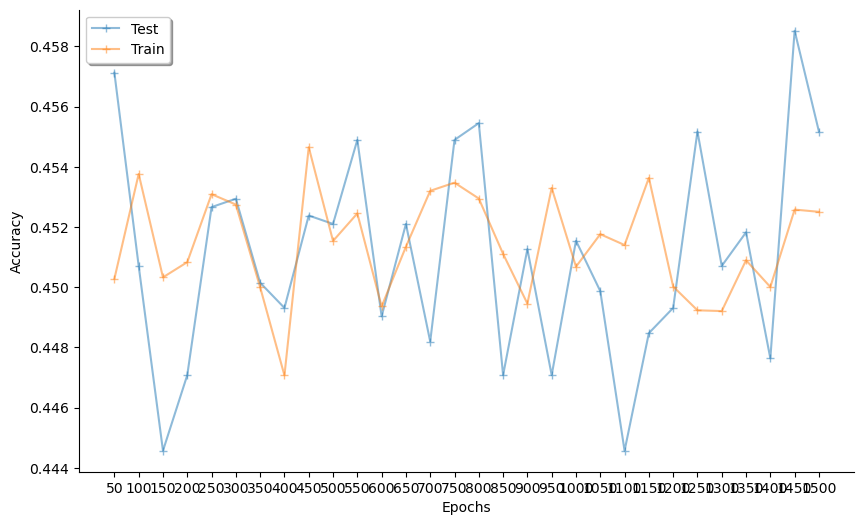

In [69]:
# plot train and validation (prediction) accuracies against each other to examine whether model overfits the training data
visualization.plot_single_performance(
                                        plots_dir=plots_dir,
                                        val_accs=val_accs,
                                        train_accs=train_accs,
                                        steps=steps,
                                        show_plot=True
)

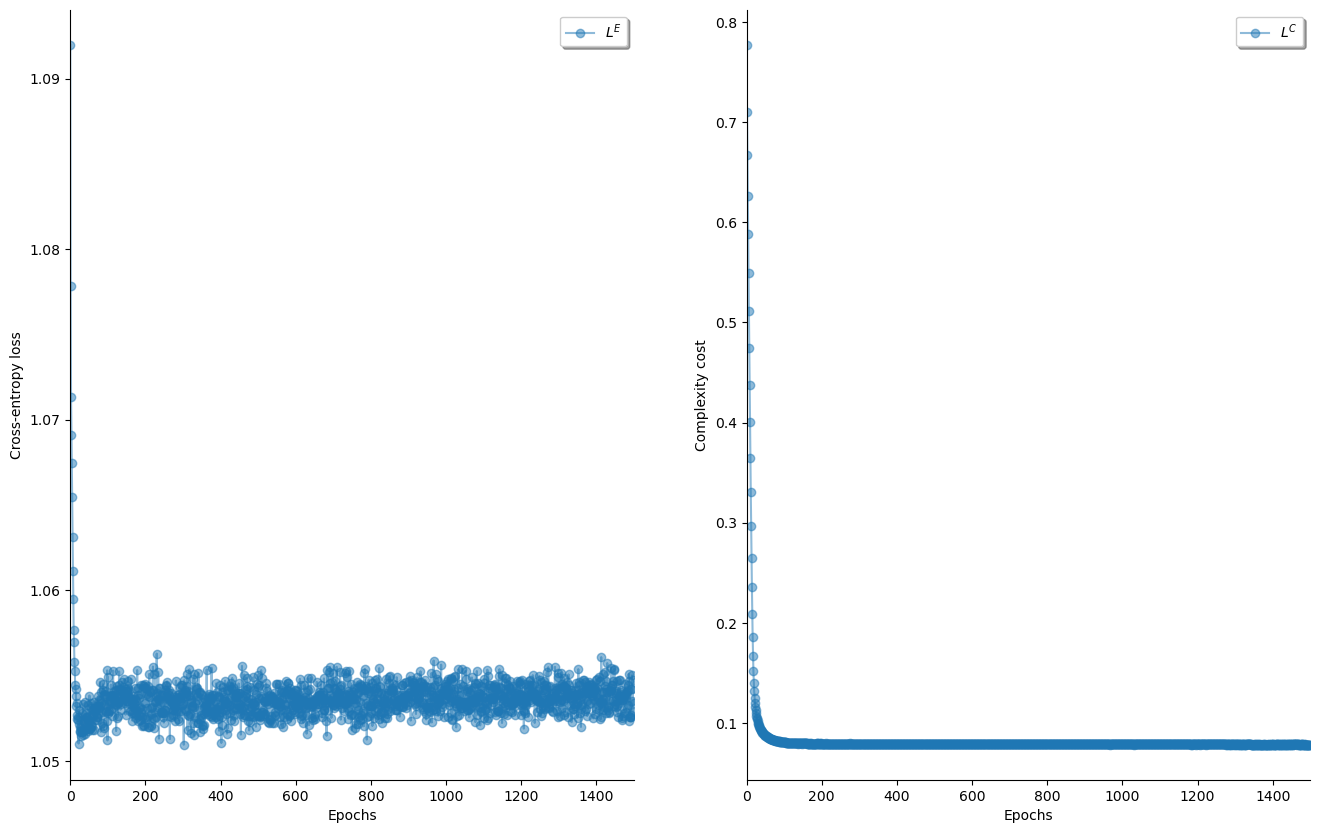

In [70]:
# plot complexity losses (KLDs) and log-likelihoods over time
visualization.plot_complexities_and_loglikelihoods(
                                                    plots_dir=plots_dir,
                                                    loglikelihoods=loglikelihoods,
                                                    complexity_losses=complexity_losses,
                                                    show_plot=True
)

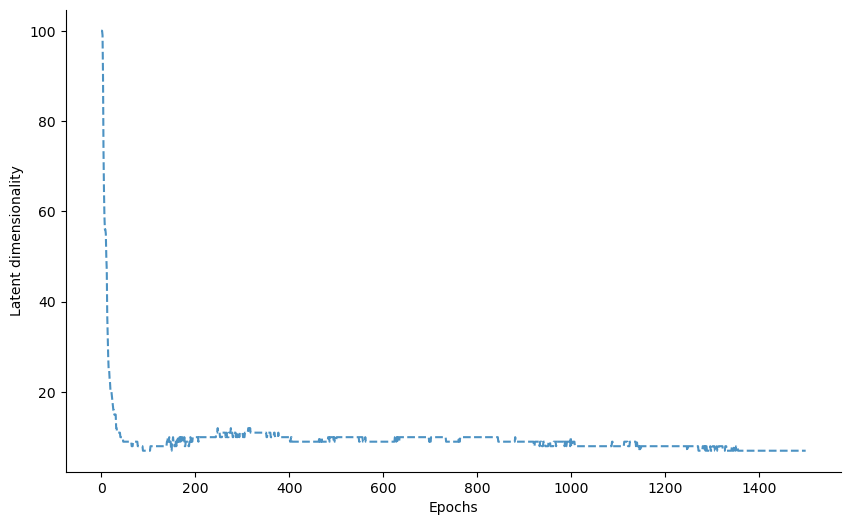

In [71]:
# plot number of latent dimensions (identified dimensions after pruning) over time
visualization.plot_latent_dimensions(
                                plots_dir=plots_dir,
                                latent_dimensions=latent_dimensions,
                                show_plot=True
)

### Save unpruned locations and scales after convergence

In [72]:
# get means and standard deviations
params = vice.detached_params
loc=params['loc']
scale=params['scale']

In [73]:
# compress model params and store as binary files
with open(os.path.join(results_dir, 'parameters.npz'), 'wb') as f:
    np.savez_compressed(f, loc=loc, scale=scale)

### Load pruned locations and scales of converged VICE model for downstream applications

In [48]:
# load pruned VICE params
pruned_params = vice.pruned_params
pruned_loc = pruned_params['pruned_loc']
pruned_scale = pruned_params['pruned_scale']